In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sps
import scipy.stats as stats

from cdf import cdf

sys.path.append("../")

In [141]:
import project_utilities as utils
from sequence_analyzer import SequenceAnalyzer

In [142]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True
prefix = "gauss"

# Simulate Gaussian Random Field

In [143]:
def covar(t, d, r):
    """covariance calculation for standard models"""
    h = d / r
    if t == 1:  # Spherical
        c = 1 - h * (1.5 - 0.5 * h ** 2)
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = np.exp(-3 * h)
    elif t == 3:  # Gaussian
        c = np.exp(-3 * h ** 2)
    return c

In [144]:
def lusimspherical(d, r, nr, vtype, seed):
    """
    LU matrix simulation for an isotropic variogram
    d: distance matrix
    r: variogram range
    nr: number of realizations
    seed: random number seed
    """
    rng = np.random.default_rng(seed)
    c = covar(vtype, d, r)
    L = np.linalg.cholesky(c)

    # Draw normal random numbers
    if nr == 1:
        x = rng.normal(0, 1, d.shape[0])
    else:
        x = rng.normal(0, 1, [d.shape[0], nr])

    # Correlate with cholesky
    x = L @ x

    return [x, c]

In [145]:
ndh = 10
ncomps = 160
dh = np.zeros(ncomps)

nx = ncomps
ny = ncomps
x0 = 0.5
y0 = 0.5
dx = 1
dy = 1
nxy = nx * ny

X, Y = np.meshgrid(
    np.linspace(x0, x0 + (nx - 1) * dx, nx),
    np.linspace(y0, y0 + (ny - 1) * dy, ny),
)
P = np.concatenate((X.reshape(nxy, 1), Y.reshape(nxy, 1)), axis=1)

In [146]:
vtype_t = [1]
xranges_t = [20]
yranges_t = [20]
c0 = 0.0
cc = [1.0]
nst = len(vtype_t)

In [147]:
Y = np.zeros((nx * ny, 1))
for i in range(nst):
    Q = P.copy()
    Q[:, 0] = Q[:, 0] / xranges_t[i]
    Q[:, 1] = Q[:, 1] / yranges_t[i]
    d = sps.distance.cdist(Q, Q)
    Y[:, i], cova = lusimspherical(
        d, r=1, nr=1, vtype=vtype_t[i], seed=78451 + i * 1000
    )
Y = Y[:, 0].reshape(ny, nx)

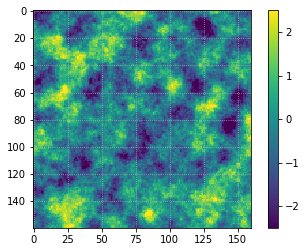

In [148]:
im = plt.imshow(Y, vmin=-2.5, vmax=2.5)
plt.colorbar(im)

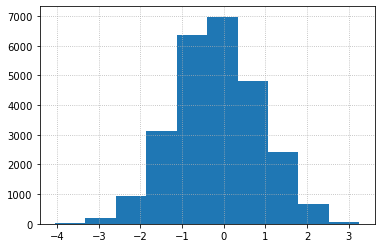

In [149]:
_ = plt.hist(Y.flatten())

# Sample Drillholes

In [150]:
np.random.seed(17)
ndh = 10
var = "var"
dhid = "dhid"
comps = pd.DataFrame(index=np.arange(ndh * ncomps), columns=[var])
comps[dhid] = np.repeat(np.arange(ndh), ncomps)
comps = comps[[dhid, var]]
# idxs = np.sort(np.random.randint(0, nx + 1, size=ndh))
idxs = np.linspace(nx / ndh, nx - (nx / ndh), ndh, dtype=int)
for i in range(ndh):
    comps.loc[comps[dhid] == i, var] = Y[:, idxs[i]]
comps = comps.astype({var: float})

'gauss_grid'

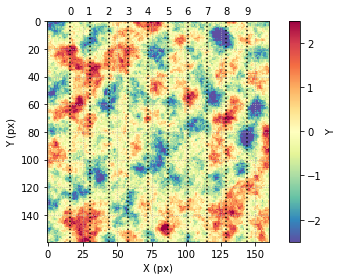

In [157]:
fig, ax = plt.subplots()
im = ax.imshow(Y, vmin=-2.5, vmax=2.5, cmap="Spectral_r")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Y")
for i, idx in enumerate(idxs):
    ax.axvline(idx, ls=":", c="k")
    ax.text(idx, -5, f"{i}", ha="center")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")
utils.savefig(f"{prefix}_grid")

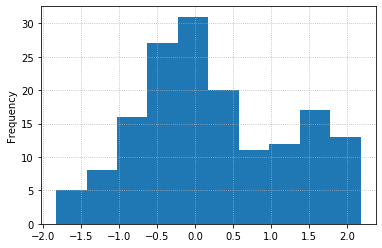

In [87]:
comps.loc[comps[dhid] == 0, var].plot(kind="hist")

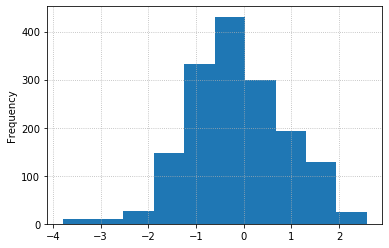

In [88]:
comps[var].plot(kind="hist")

# Sequence Analyzer

In [89]:
sa = SequenceAnalyzer(
    comps,
    dhid,
    var,
    #     quantiles=np.arange(10, 100, 10),
    quantiles=[10, 50, 90],
    scale_factors=[1, 5, 10, 15, 20, 25, 30, 35, 40],
    nreals=100,
    seed=21,
    runs_above=True,
)

In [ ]:
sa = SequenceAnalyzer(
    data=comps,
    dhid=dhid,
    var=var,
    quantiles=[10, 50, 90],
    scale_factors=[1, 5, 10, 15],
    nreals=100,
    seed=21,
    runs_above=True,
)

'gauss_reals'

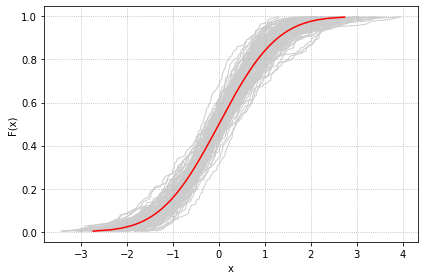

In [90]:
dh = 6
sa.check_reals(dh)
utils.savefig(f"{prefix}_reals")

'gauss_reals_bt'

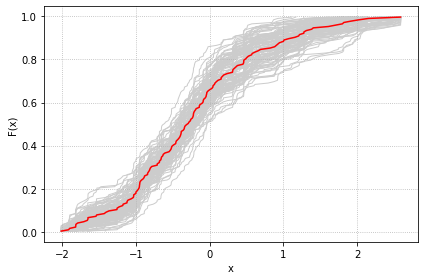

In [91]:
sa.check_reals(dh, gauss=False, log=False)
utils.savefig(f"{prefix}_reals_BT")

# Variogram Test

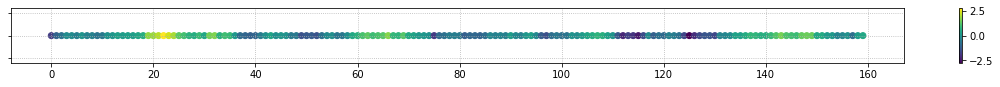

In [92]:
test_dhid = 0
test_dh = sa.dh_dict[test_dhid]["ns_data"]
expvario = sa.oned_variogram(test_dh)
_ = sa.plot_dh(dh=test_dhid)

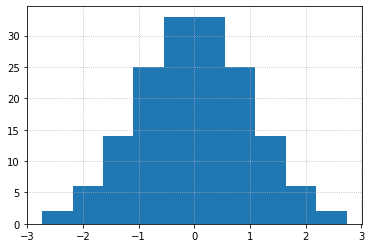

In [93]:
_ = plt.hist(test_dh)

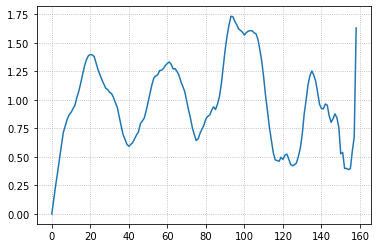

In [94]:
plt.plot(expvario)

In [95]:
def covar(t, d, r):
    """covariance calculation for standard models"""
    h = d / r
    if t == 1:  # Spherical
        c = 1 - h * (1.5 - 0.5 * h ** 2)
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = np.exp(-3 * h)
    elif t == 3:  # Gaussian
        c = np.exp(-3 * h ** 2)
    return c

In [96]:
def lusimspherical(d, r, nr, vtype, seed):
    """
    LU matrix simulation for an isotropic variogram
    d: distance matrix
    r: variogram range
    nr: number of realizations
    seed: random number seed
    """
    rng = np.random.default_rng(seed)
    c = covar(vtype, d, r)
    L = np.linalg.cholesky(c)

    # Draw normal random numbers
    if nr == 1:
        x = rng.normal(0, 1, d.shape[0])
    else:
        x = rng.normal(0, 1, [d.shape[0], nr])

    # Correlate with cholesky
    x = L @ x

    return [x, c]

In [97]:
import scipy.spatial as sps

vtype = [1]
xranges = [13]
c0 = 0.0
cc = [1.0]
nst = len(vtype)
cova = np.zeros_like(test_dh)
P = np.arange(len(test_dh)) + 0.5
nx = test_dh.shape[0]

for i in range(nst):
    Q = P.copy()
    Q = Q / xranges[i]
    d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
    cova = cova + cc[i] * covar(vtype[i], d, r=1)
target_x = 1 - cova[0:nx, 0]
cx = cova[0:nx, 0]

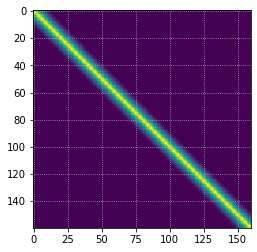

In [98]:
vmin = 0
vmax = 1
plt.imshow(cova, vmin=vmin, vmax=vmax)

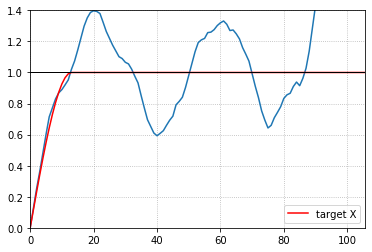

In [99]:
fig, ax = plt.subplots()
ax.plot(expvario)
ax.plot(target_x, label="target X", c="r")
ax.axhline(1.0, c="k", lw=1)
ax.set_xlim(0, nx * 0.66)
ax.set_ylim(0, 1.4)
ax.legend(loc=4)

In [100]:
nreals = 100
Y = np.zeros([len(test_dh), nreals])
Q = P.copy()
Q = Q / xranges[i]
d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
Y, cova = lusimspherical(d, r=1, nr=nreals, vtype=vtype[i], seed=21)

Z = np.zeros_like(Y)
nscorer = sa.dh_dict[test_dhid]["ns_transformer"]
for ireal in range(sa.nreals):
    Z[:, ireal] = nscorer.inverse_transform(Y[:, ireal])

In [101]:
# import rmsp

# rmsp.activate()

# griddef = rmsp.GridDef(
#     0,
#     0,
#     0,
#     nu=nx,
#     nv=1,
#     nz=1,
#     usize=1,
#     vsize=1,
#     zsize=1,
#     blockindices=np.arange(nx),
# )
# grid = rmsp.GridData(griddef=griddef)

# vario_dict = dict(
#     num_struct=1,
#     nugget=0.0,
#     shapes=["spherical"],
#     var_contribs=[1.0],
#     angles=[[90.0, 0.0, 0.0]],
#     ranges=[[13, 1, 1]],
# )
# vario = rmsp.VarioModel(vario_dict)

# fig, ax = plt.subplots()
# vario.plot(ax=ax)
# ax.plot(expvario, marker=".", ls="None")

# sim = rmsp.Simulator()
# reals = sim.uncond_simulate(grid, vario, reals=100, seed=1044)

# Y = np.zeros((nx, nreals))
# for i in range(nreals):
#     Y[:,i] = reals.get_real(i).values.ravel()

# print(Y[:, 0].mean(), Y[:, 0].std())
# fig, ax = plt.subplots()
# _ = ax.hist(Y[:, 0])

# Continuous Variance

In [102]:
def colorgt(value):
    color = "red" if value >= 3.0 else "k"
    return f"color: {color}"

In [103]:
df = sa.nongauss_measure("scale_continuous")
utils.savetab(df, f"{prefix}_cont_var.tex")
df.style.applymap(colorgt)

,Scale Factor 1,Scale Factor 5,Scale Factor 10,Scale Factor 15,Scale Factor 20,Scale Factor 25,Scale Factor 30,Scale Factor 35,Scale Factor 40
dhid,,,,,,,,,
0,0.119173,0.343821,0.583512,0.663841,0.140571,0.952969,1.159914,0.444862,0.059403
1,0.038418,0.290053,0.398352,0.286066,0.307967,1.019775,0.754488,0.257025,0.087144
2,0.021282,0.173934,0.302117,0.165039,0.094570,0.031404,0.557102,0.244699,0.740136
3,0.115080,0.184720,0.333577,0.348950,0.383532,0.587887,0.900936,0.198312,0.567067
4,0.030631,0.117274,0.322599,0.612481,0.328030,0.322985,0.795766,0.704441,0.202562
5,0.038223,0.160993,0.109943,0.309735,0.489646,0.996467,1.208775,1.364142,0.901004
6,0.083621,0.124116,0.259353,0.205540,0.120689,0.453401,0.849332,0.644471,0.346351
7,0.119933,0.163835,0.148855,0.103500,0.274853,0.094318,0.164509,0.457511,0.749456
8,0.153096,0.300743,0.390492,0.284003,0.893005,0.683449,0.748467,0.290209,0.557630


In [104]:
df.max()

Scale Factor 1     0.153096
Scale Factor 5     0.343821
Scale Factor 10    0.583512
Scale Factor 15    0.663841
Scale Factor 20    0.893005
Scale Factor 25    1.019775
Scale Factor 30    1.208775
Scale Factor 35    1.364142
Scale Factor 40    0.901004
dtype: float64

In [105]:
# test traditional variogram model
# ds_reals = {f: sa._downsample_realizations(Y, f) for f in sa.scale_factors}
ds_reals = {f: sa._downsample_realizations(Z, f) for f in sa.scale_factors}

cont_var = {f: [] for f in sa.scale_factors}
cont_mean = {f: [] for f in sa.scale_factors}

for f in sa.scale_factors:
    for ireal in range(sa.nreals):
        cont_var[f].append(np.var(ds_reals[f][:, ireal]))
        cont_mean[f].append(np.mean(ds_reals[f][:, ireal]))

df = pd.DataFrame(columns=[f"Scale Factor {f}" for f in sa.scale_factors])
df.index.name = sa.dhid
for f in sa.scale_factors:
    x = sa.dh_dict[test_dhid]["cont_var"][f]
    df.loc[test_dhid, f"Scale Factor {f}"] = np.abs(
        sa.standardize(x, cont_var[f])
    )
df.style.applymap(colorgt)

,Scale Factor 1,Scale Factor 5,Scale Factor 10,Scale Factor 15,Scale Factor 20,Scale Factor 25,Scale Factor 30,Scale Factor 35,Scale Factor 40
dhid,,,,,,,,,
0,0.241758,0.411395,0.691967,0.866099,0.316343,0.921434,1.035930,0.231423,0.351295


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb21af8888>)

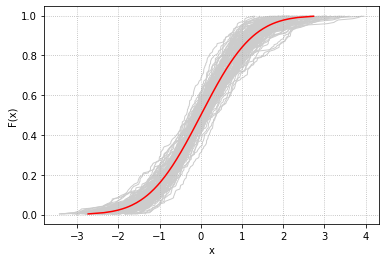

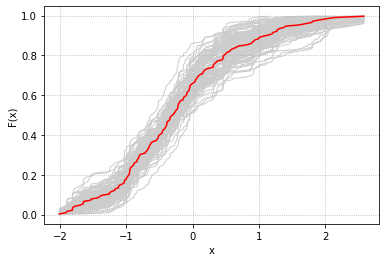

In [106]:
dh = 6
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

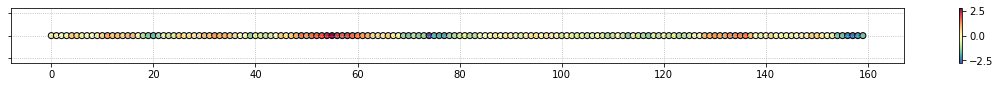

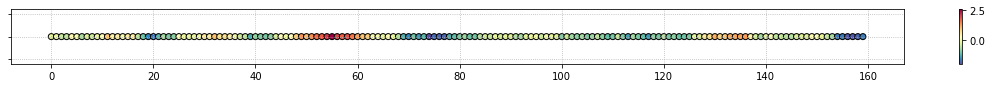

In [107]:
_ = sa.plot_dh(dh, cmap="Spectral_r", ec="k")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r", ec="k")

'gauss_cont_var'

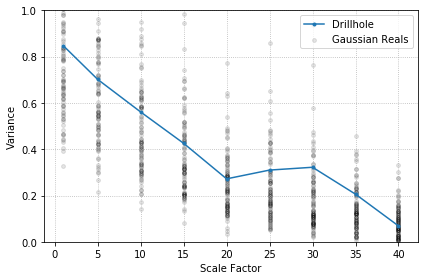

In [108]:
fig, ax = sa.diagnostic_plot("scale_continuous", dh)
ax.set_ylim(0, 1.0)
utils.savefig(f"{prefix}_cont_var")

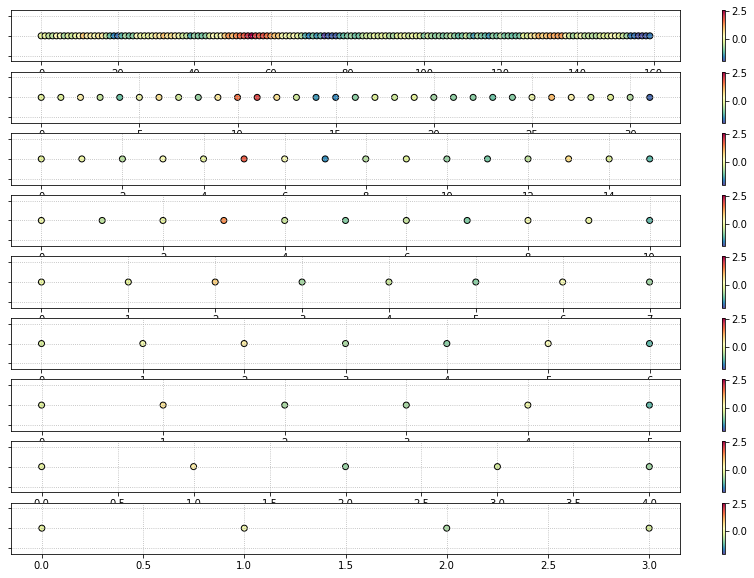

In [109]:
vmin = sa.dh_dict[dh]["x_numpy"].min()
vmax = sa.dh_dict[dh]["x_numpy"].max()

_ = sa.plot_downscaled_dh(dh, cmap="Spectral_r", ec="k", vmin=vmin, vmax=vmax)

# Total Runs

In [110]:
df = sa.nongauss_measure("total_runs")
utils.savetab(df, f"{prefix}_total_runs.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.5 Indicator,0.9 Indicator
dhid,,,
0,0.932025,0.044342,0.051697
1,0.559201,0.502693,0.827641
2,2.127038,0.249145,0.178948
3,1.588084,0.110020,0.248133
4,0.357060,0.170435,0.209349
5,0.598662,0.850034,0.736444
6,0.553996,0.013579,0.301528
7,0.480010,0.049707,0.000000
8,1.931142,0.131996,0.470794


In [111]:
df.max()

0.1 Indicator    2.127038
0.5 Indicator    0.850034
0.9 Indicator    0.827641
dtype: float64

In [112]:
# test traditional variogram model
# ind_reals = sa._realization_indicator_transform(Y)
ind_reals = sa._realization_indicator_transform(Z)

runs_reals = {
    q / 100: sa._binary_runs_realizations(ind_reals[q / 100])
    for q in sa.quantiles
}

df = pd.DataFrame(columns=[f"{q} Indicator" for q in sa.thresholds.keys()])
df.index.name = sa.dhid
for q, t in sa.thresholds.items():
    tot_runs = []
    for ireal in range(sa.nreals):
        tot_runs.append(len(runs_reals[q]["cum_runs"][ireal]))
    x = len(sa.dh_dict[test_dhid]["runs"][q]["cum_runs"])
    df.loc[test_dhid, f"{q} Indicator"] = np.abs(sa.standardize(x, tot_runs))
df

,0.1 Indicator,0.5 Indicator,0.9 Indicator
dhid,,,
0,0.884498,0.2344,0.0961739


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9e5e53c88>)

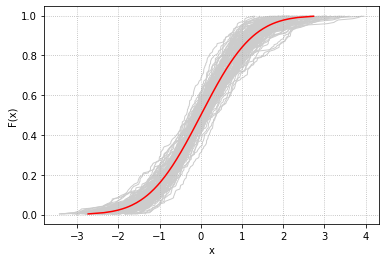

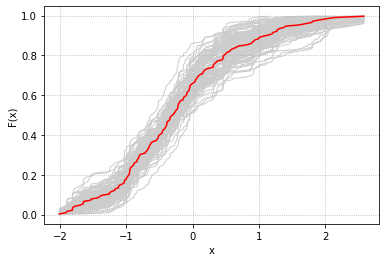

In [113]:
dh = 6
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

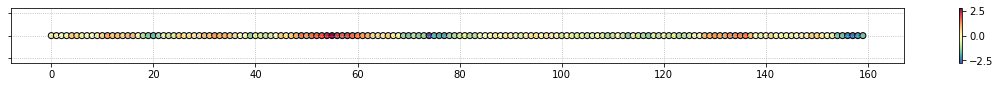

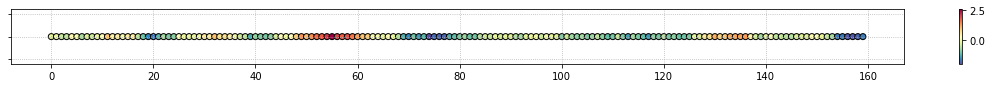

In [114]:
_ = sa.plot_dh(dh, cmap="Spectral_r", ec="k")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r", ec="k")

'gauss_total_runs'

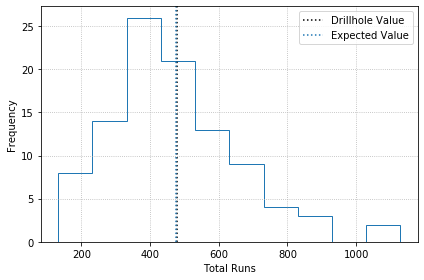

In [115]:
q = 0.5
_ = sa.diagnostic_plot("total_runs", dh, q)
utils.savefig(f"{prefix}_total_runs")

'gauss_indicators'

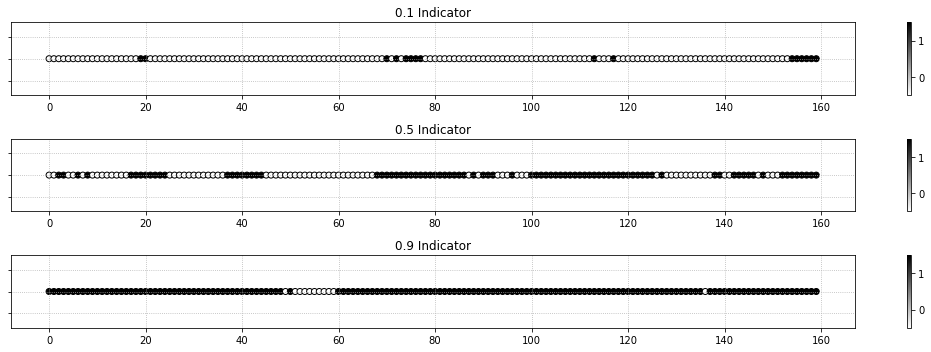

In [121]:
fig, ax = sa.plot_indicators(dh, cmap="binary", ec="k", figsize=(15, 5))
fig.tight_layout()
utils.savefig(f"{prefix}_indicators", bbox_inches="tight")

'gauss_dh'

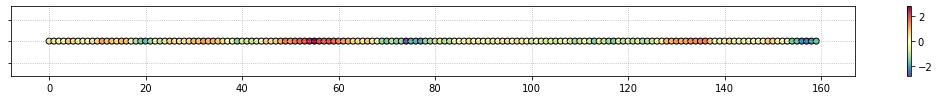

In [117]:
fig, ax = sa.plot_dh(dh, cmap="Spectral_r", ec="k", figsize=(15, 1.5))
fig.tight_layout()
utils.savefig(f"{prefix}_dh", bbox_inches="tight")

# Cumulative Runs

In [68]:
df = sa.nongauss_measure("run_length_freqs", max_runs=30)
utils.savetab(df, f"{prefix}_run_length_freqs.tex")
df.style.applymap(colorgt)

C:\Users\benha\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\benha\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,0.886655,1.159564,0.474407,0.538138,0.195587,0.833661,0.943232,0.627975,0.267011
1,0.266205,0.987183,0.712496,0.452705,0.630897,1.029271,1.036942,0.417109,0.867365
2,1.454942,0.235928,1.143049,0.290697,0.347695,0.092441,0.297512,0.883616,0.137035
3,0.915225,0.512560,0.239498,0.318638,0.186812,0.440594,0.109569,0.137079,0.177517
4,0.063780,0.089785,0.702079,0.346948,0.320831,0.232516,0.179066,0.405601,0.139993
5,0.209881,0.509838,0.101838,0.381983,0.967431,0.911278,2.155219,0.664347,0.924657
6,0.334045,0.371554,0.408046,0.374351,0.169059,0.397526,0.534320,1.111625,0.410255
7,0.621286,0.474417,0.275623,0.308907,0.084865,0.315477,0.200370,0.303503,nan
8,1.080964,0.488302,0.342786,0.306433,0.055299,0.187197,0.215258,0.177452,0.472462


In [69]:
df.max()

0.1 Indicator    1.454942
0.2 Indicator    1.159564
0.3 Indicator    1.143049
0.4 Indicator    0.538138
0.5 Indicator    0.967431
0.6 Indicator    1.029271
0.7 Indicator    2.155219
0.8 Indicator    1.111625
0.9 Indicator    0.924657
dtype: float64

In [70]:
# test traditional variogram
max_runs = 30
df = pd.DataFrame(columns=[f"{q} Indicator" for q in sa.thresholds.keys()])
df.index.name = sa.dhid

for q, t in sa.thresholds.items():
    dh_runs = sa.dh_dict[test_dhid]["runs"][q]["cum_runs_freqs"]
    nruns = min(len(dh_runs), max_runs)
    temp = np.zeros((sa.nreals, len(sa.dh_dict[test_dhid]["x_numpy"])))
    for ireal in range(sa.nreals):
        real_run_freqs = runs_reals[q]["cum_runs_freqs"][ireal]
        idxs = np.arange(len(real_run_freqs))
        temp[ireal, idxs] = real_run_freqs
    x = dh_runs[:nruns]
    d = temp[:, :nruns]
    scores = [sa.standardize(x[i], d[:, i]) for i in range(nruns)]
    score = np.mean(np.abs(scores))
    df.loc[test_dhid, f"{q} Indicator"] = score
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,0.790097,0.951024,0.443394,0.508028,0.127435,0.407278,0.698261,0.452378,0.169715


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9e9c475c8>)

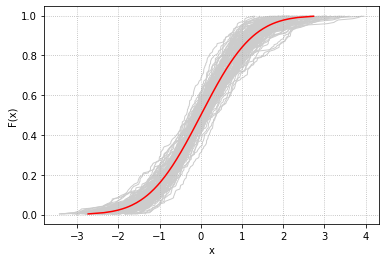

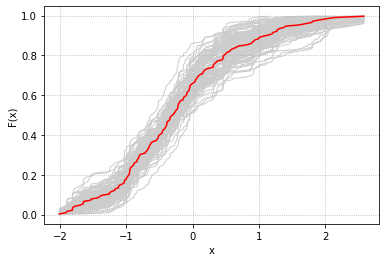

In [158]:
dh = 6
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

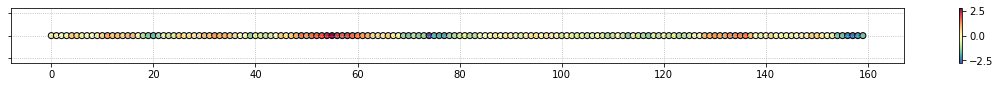

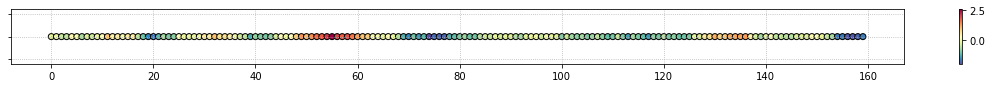

In [159]:
_ = sa.plot_dh(dh, cmap="Spectral_r", ec="k")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r", ec="k")

'gauss_run_length_freqs'

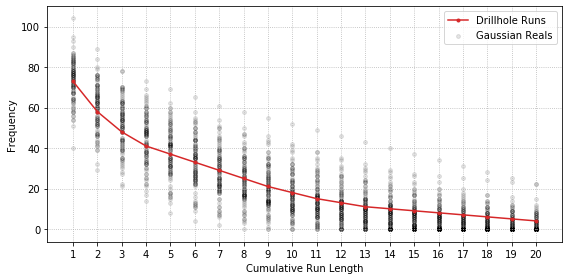

In [161]:
q = 0.5
f = None
max_runs = 20
figsize = (8, 4)
_ = sa.diagnostic_plot(
    "run_length_freqs", dh, q, max_runs=max_runs, figsize=figsize
)
utils.savefig(f"{prefix}_run_length_freqs")

# h-Scatter

0.7850836021690604


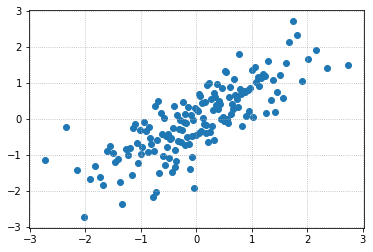

In [51]:
# h-scatter
x = sa.dh_dict[4]["ns_data"]
array = np.array(x)
nx = array.shape[0]
cx = np.zeros(nx - 1)
h = 3
for i in range(1, h):
    z0 = array[0 : nx - i]
    z1 = array[i:nx]
    dz = (z1 * z0) - np.mean(z0) * np.mean(z1)
    cx[i] = np.sum(dz) / (nx - i)
plt.scatter(z0, z1)
print(np.cov(z0, z1)[0, 1])

0.0949367088607595
0.0759493670886076


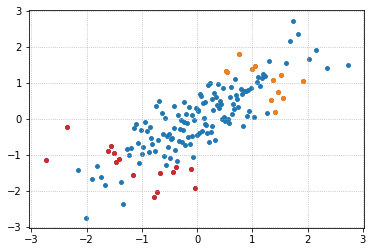

In [52]:
thresh = 1.28
mask1 = ((z0 < -thresh) & (z1 >= -thresh)) | ((z0 >= -thresh) & (z1 < -thresh))
mask2 = ((z0 < thresh) & (z1 >= thresh)) | ((z0 >= thresh) & (z1 < thresh))
plt.scatter(z0, z1, s=15)
plt.scatter(z0[mask1], z1[mask1], c="C3", s=15)
plt.scatter(z0[mask2], z1[mask2], c="C1", s=15)
print(sum(mask1) / len(z0))
print(sum(mask2) / len(z0))

# n-Point Connectivity

In [53]:
nstep = 20
df = sa.nongauss_measure("n_pt_connectivity", nstep=nstep)
utils.savetab(df, f"{prefix}_n_pt_connectivity.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,0.131746,0.152828,0.134982,0.304358,0.182370,0.171737,0.274276,0.260251,0.123269
1,0.178297,0.163091,0.421887,0.594148,0.494105,0.504236,0.577262,0.545665,0.123044
2,0.146360,0.476627,0.101529,0.138751,0.115073,0.072985,0.043600,0.165928,0.149797
3,0.267808,0.299329,0.177586,0.094830,0.087407,0.064324,0.305851,0.246841,0.078137
4,0.350550,0.191661,0.109305,0.256543,0.444572,0.338138,0.373401,0.381736,0.371922
5,0.216005,0.346899,0.040475,0.087275,0.203645,0.354411,0.487200,0.463711,0.252858
6,0.187594,0.076150,0.123906,0.132998,0.086192,0.043949,0.097396,0.100356,0.094230
7,0.110669,0.165164,0.237004,0.092347,0.181394,0.182726,0.100273,0.039936,0.000000
8,0.300541,0.037637,0.067024,0.059113,0.059017,0.087856,0.065510,0.166829,0.170791


'gauss_n_pt_connectivity'

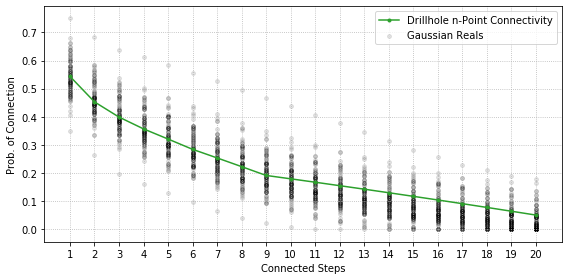

In [162]:
dh = 6
q = 0.5
f = None
max_runs = None

figsize = (8, 4)
fig, ax = sa.diagnostic_plot(
    "n_pt_connectivity", dh, q, f, max_runs, nstep, figsize
)
# ax.set_ylim(top=1.0)
utils.savefig(f"{prefix}_n_pt_connectivity")

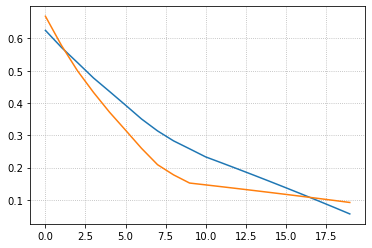

In [65]:
def n_pt_conn(x, nstep):
    """n-point connectivity fucntion of binary array x"""
    x = np.asarray(x)
    nx = x.shape[0]
    phi_n = []
    for n in range(1, nstep + 1):
        prod = []
        for i in range(nx - n + 1):
            idxs = [i] + [j + i for j in range(n)]
            a = [x[idx] for idx in idxs]
            prod.append(np.prod(a))
        phi_n.append(np.mean(prod))
    return phi_n


dh = 5
ireal = 8
q = 0.5
ind = sa.dh_dict[dh]["indicators"][f"{q} Indicator"].values
plt.plot(n_pt_conn(ind, nstep))
plt.plot(n_pt_conn(sa.dh_dict[dh]["ind_reals"][q][:, ireal], nstep))

In [163]:
test_dh = sa.dh_dict[dh]["x_numpy"]

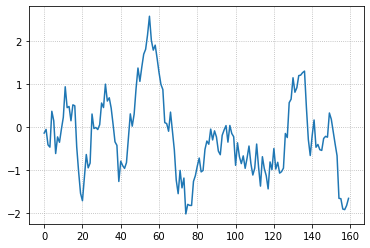

In [164]:
plt.plot(test_dh)

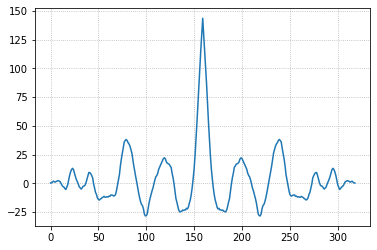

In [166]:
plt.plot(np.correlate(test_dh, test_dh, "full"))